In [28]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [127]:
#required libraries
import re
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')

In [128]:
# Load the data file
df = pd.read_csv("spam.csv",  encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [129]:
df.shape

(5572, 5)

#### *Data cleaning*

In [130]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [131]:
#drop unuses columns
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

#Rename the columns name
df.rename(columns={'v1':'target', 'v2':'message'}, inplace = True)
df.sample(5)

,target,message
4406,ham,"Awesome, plan to get here any time after like ..."
2633,ham,That's what I love to hear :V see you sundayis...
1720,ham,"Fighting with the world is easy, u either win ..."
627,ham,Yup i thk they r e teacher said that will make...
5002,spam,CDs 4u: Congratulations ur awarded å£500 of CD...


In [132]:
#check missing value
df.isnull().sum()

target     0
message    0
dtype: int64

In [133]:
#Check duplicate value
df.duplicated().sum()

403

In [134]:
# remove duplicates
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

In [135]:
df.shape

(5169, 2)

#### *Basic EDA*

In [136]:
df.head(5)

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [137]:
# data distribution
df['target'].value_counts()

ham     4516
spam     653
Name: target, dtype: int64

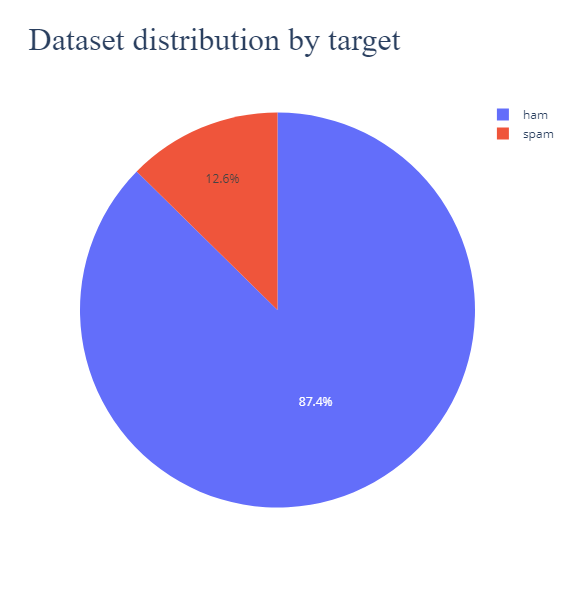

In [138]:
# visualization 
import plotly.graph_objects as go

value_counts = df['target'].value_counts()

# Create pie chart
fig = go.Figure(data=[go.Pie(labels=value_counts.index, values=value_counts.values)])

# Update layout
fig.update_layout(
    width=800, 
    height=600,
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)


# Show the pie chart
fig.show()

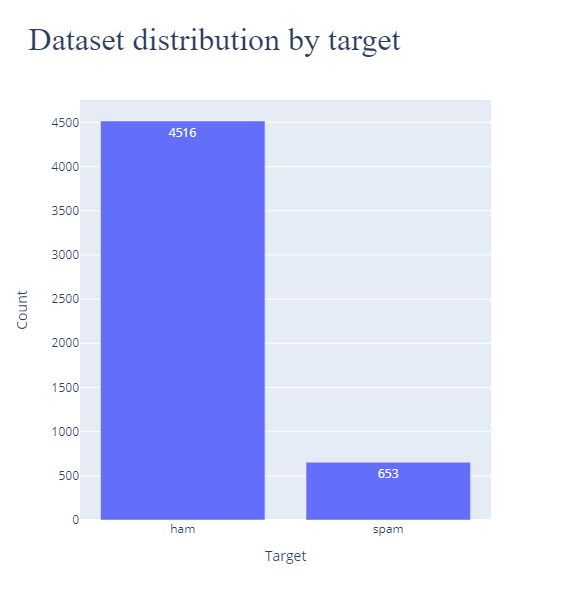

In [139]:
# Get the value counts of the 'target' column
value_counts = df['target'].value_counts()

# Create bar plot
fig = go.Figure(data=[go.Bar(
    x=value_counts.index,
    y=value_counts.values,
    text=value_counts.values,  # Display counts on top of bars
    textposition='auto',  # Position text automatically
)])

# Update layout with figure size and title
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>',
    xaxis=dict(title='Target'),
    yaxis=dict(title='Count'),
    width=800,  # Set the width of the figure
    height=600  # Set the height of the figure
)

# Show the bar plot
fig.show()

In [140]:
# now create new variable for number of character in meassage
df['number_of_characters'] = df['message'].apply(len)
df.head()

,target,message,number_of_characters
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [141]:
max(df['number_of_characters'])

910

In [90]:
df[df['number_of_characters'] == 910].loc[1084, 'message']

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [94]:
df[df['number_of_characters'] == 111].loc[0, 'message']

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [142]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [143]:
# num of words
df['num_words'] = df['message'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,message,number_of_characters,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",111,24
1,ham,Ok lar... Joking wif u oni...,29,8
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,ham,U dun say so early hor... U c already then say...,49,13
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15


In [144]:
# nmber of sentence
df['num_sentences'] = df['message'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head(5)

,target,message,number_of_characters,num_words,num_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [145]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_characters,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,910.0
num_words,5169.0,18.453279,13.324793,1.0,9.0,15.0,26.0,220.0
num_sentences,5169.0,1.947185,1.362406,1.0,1.0,1.0,2.0,28.0


#### *Target column*

In [146]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df.head()

,target,message,number_of_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


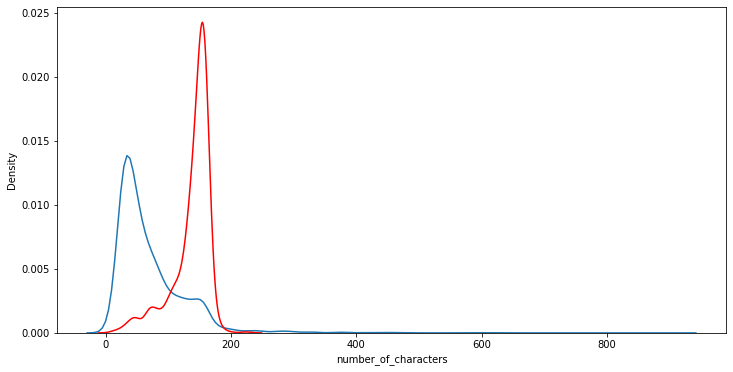

In [147]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.kdeplot(df[df['target'] == 0]['number_of_characters'])
sns.kdeplot(df[df['target'] == 1]['number_of_characters'],color='red')
plt.show()

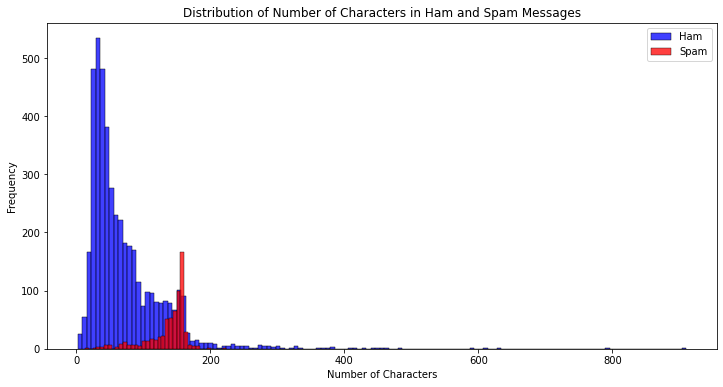

In [148]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target'] == 0]['number_of_characters'], color='blue', label='Ham')
sns.histplot(df[df['target'] == 1]['number_of_characters'], color='red', label='Spam')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Characters in Ham and Spam Messages')
plt.legend()
plt.show()

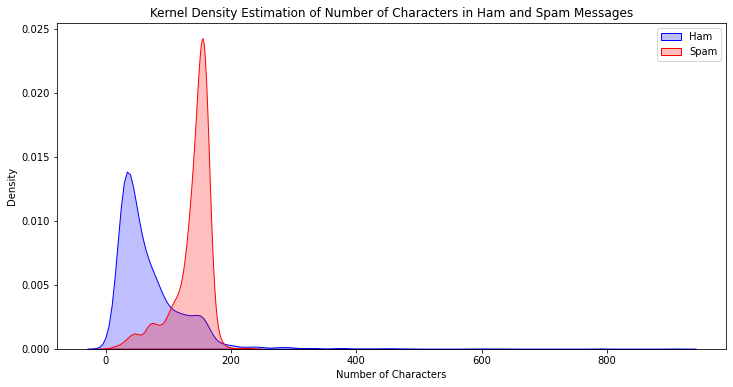

In [149]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df[df['target'] == 0]['number_of_characters'], color='blue', label='Ham', fill=True)
sns.kdeplot(data=df[df['target'] == 1]['number_of_characters'], color='red', label='Spam', fill=True)
plt.xlabel('Number of Characters')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Number of Characters in Ham and Spam Messages')
plt.legend()
plt.show()

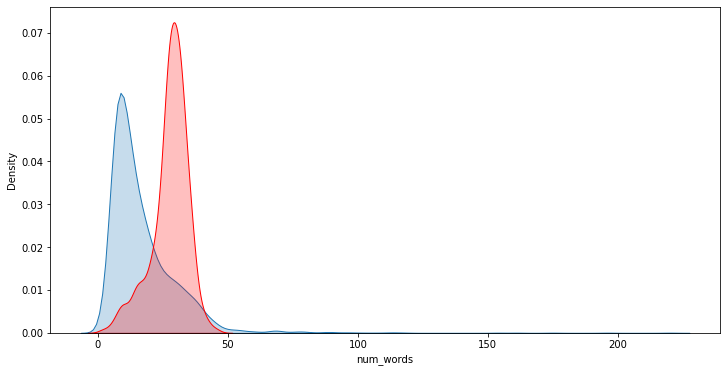

In [153]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.kdeplot(df[df['target'] == 0]['num_words'], fill = True)
sns.kdeplot(df[df['target'] == 1]['num_words'],color='red', fill = True)
plt.show()

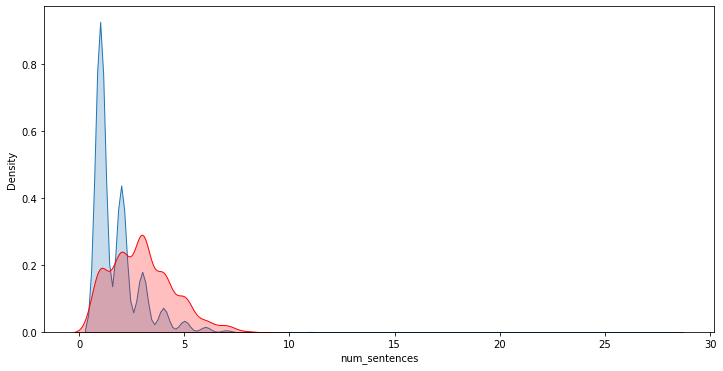

In [155]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.kdeplot(df[df['target'] == 0]['num_sentences'], fill = True)
sns.kdeplot(df[df['target'] == 1]['num_sentences'],color='red', fill = True)
plt.show()

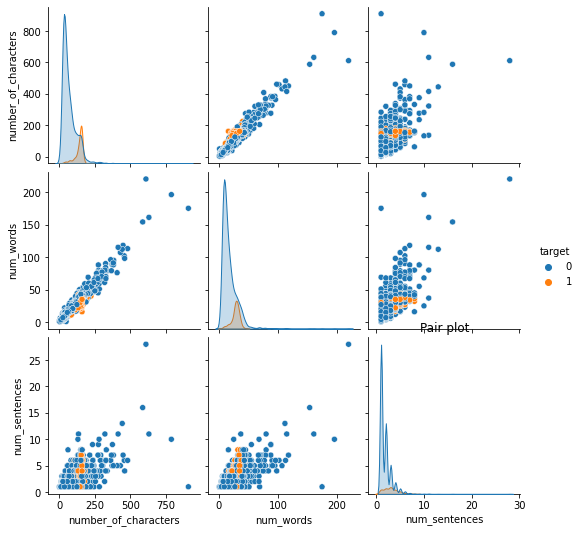

In [157]:
sns.pairplot(df,hue='target')

plt.show()

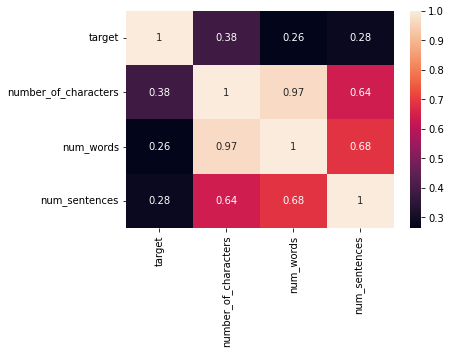

In [158]:
sns.heatmap(df.corr(),annot=True)
plt.show()

### *Text preprocessing*

##### *Cleaning the corpus*

In [159]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [160]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,number_of_characters,num_words,num_sentences,message_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i dont think he goes to usf he lives aroun...


In [164]:
df['message_clean'][0]

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'

##### *Stop wirds*

In [166]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,target,message,number_of_characters,num_words,num_sentences,message_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry wkly comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,49,13,1,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah dont think goes usf lives around though


In [167]:
df['message_clean'][0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

#### *Stemming*

In [168]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [169]:
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,number_of_characters,num_words,num_sentences,message_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri wkli comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,49,13,1,dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah dont think goe usf live around though


In [170]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [171]:
df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,number_of_characters,num_words,num_sentences,message_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri wkli comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,49,13,1,dun say ear hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah dont think goe usf live around though


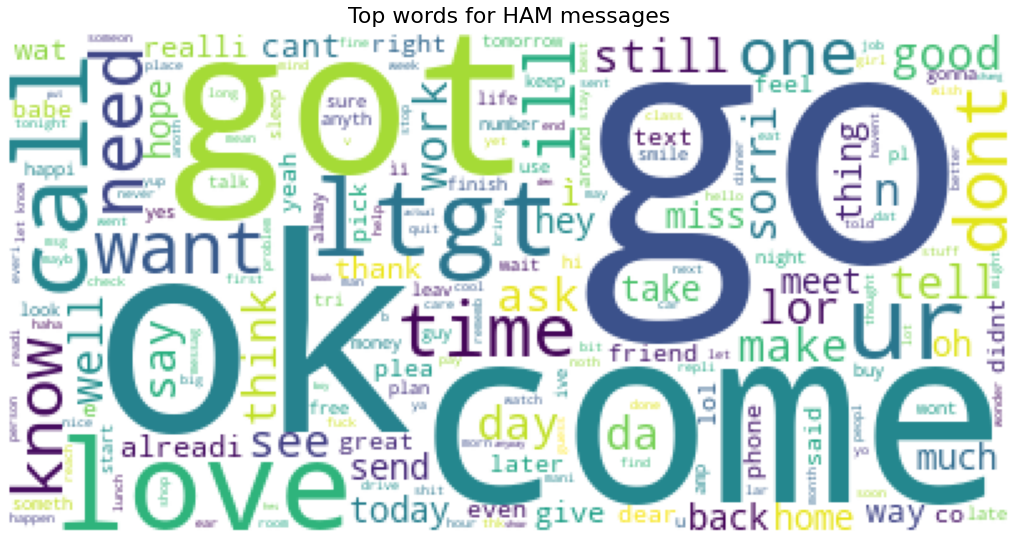

In [174]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a WordCloud object
wc = WordCloud(
    background_color='white', 
    max_words=200, 
   
)

# Generate the word cloud for ham messages
ham_messages = df[df['target'] == 0]['message_clean']  # Assuming 'message_clean' contains cleaned text
wc.generate(' '.join(text for text in ham_messages))

# Plot the word cloud
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


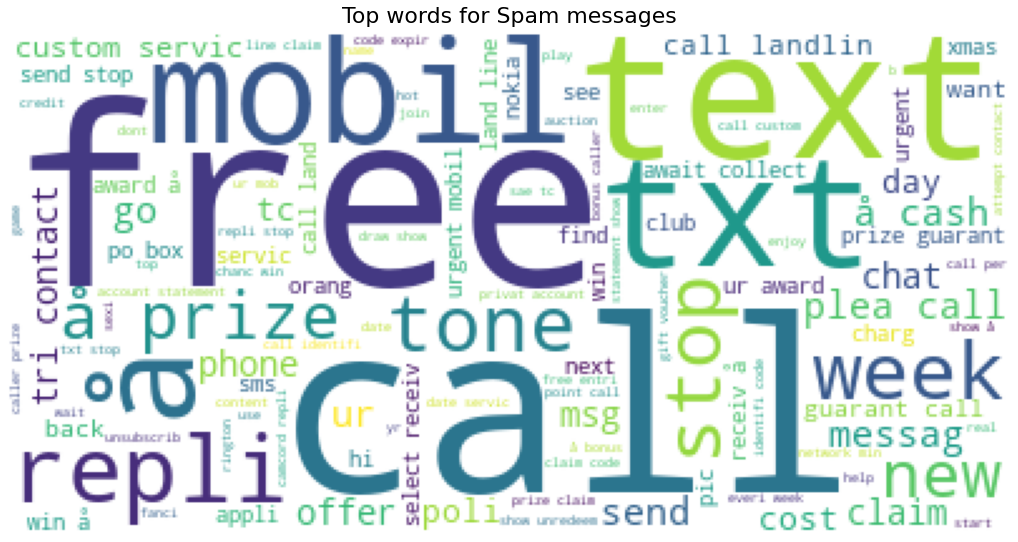

In [175]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a WordCloud object
wc = WordCloud(
    background_color='white', 
    max_words=200, 
   
)

# Generate the word cloud for ham messages
ham_messages = df[df['target'] == 1]['message_clean']  # Assuming 'message_clean' contains cleaned text
wc.generate(' '.join(text for text in ham_messages))

# Plot the word cloud
plt.figure(figsize=(18,10))
plt.title('Top words for Spam messages', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


#### *Vectorization*

In [55]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [56]:
max(df['message_len'])

171

In [62]:
df[df['message_len'] == 171].loc[1084, 'message']

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [95]:
text = """
'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'
"""
# Message length (number of characters)
message_len = len(text)

# Word count
word_count = len(text.split())

# Number of sentences
sentences = re.split(r'[.!?]+', text)
# Filter out empty strings (e.g., caused by multiple punctuation marks)
sentences = [sentence for sentence in sentences if sentence]
num_sentences = len(sentences)

# Print results
print("Message Length (Number of Characters):", message_len)
print("Word Count:", word_count)
print("Number of Sentences:", num_sentences)

Message Length (Number of Characters): 115
Word Count: 20
Number of Sentences: 4
